Note to self 6/4-22:
Totalt antall stemmer godt med PSAK120.
Alt med DP stemmer bra med excel, men ikke så bra med PSAK120.
Automatisk stemmer så bra at autograd blir det samme på figur 1, men litt unøyaktighet her også.


For the future 22/4-22:
Når vi joiner med `PEN.T_SKJEMA` forsvinner (nesten) alle ikke-selvbetjente saker. Teste ut andre typer join for å konservere antall saker. Hvordan håndtere resulterende nullverdier fra `PEN.T_SKJEMA`?
Kan være nødvendig å se mer på `OPPRETTET_AV`; mye der som kommer fra batch.

In [188]:
import cx_Oracle
import pandas as pd
import numpy as np
import sys
import os
import importlib
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from google.cloud import secretmanager

sys.path.append('../lib')
import pandas_utils

importlib.reload(pandas_utils)

<module 'pandas_utils' from '../lib/pandas_utils.py'>

In [189]:
secrets = secretmanager.SecretManagerServiceClient()
resource_name = f"projects/knada-gcp/secrets/vebjorns-hemmelighet/versions/latest"
secret = secrets.access_secret_version(name=resource_name)
secrets = dict([line.split(":") for line in secret.payload.data.decode('UTF-8').splitlines()])

ORACLE_HOST = '10.53.136.15'
ORACLE_PORT = '1521'
ORACLE_SERVICE = 'pen'

In [190]:
dsnStr = cx_Oracle.makedsn(ORACLE_HOST, ORACLE_PORT, service_name=ORACLE_SERVICE)

In [191]:
con = cx_Oracle.connect(user=secrets["PEN_USER"], password=secrets["PEN_PASSWORD"],
                               dsn=dsnStr)

In [192]:
df_v1 = pandas_utils.pandas_from_sql('../sql/v1.sql', con)

In [193]:
con.close()

In [194]:
df_v1.tail(16)

,ÅR,MÅNED,OPPRETTET_AV,AUTOMATISERING,ANTALL
650,2022,2,bruker,AUTO,2105
651,2022,2,bruker,MAN,1455
652,2022,2,saksbehandler,AUTO,42
653,2022,2,saksbehandler,MAN,908
654,2022,3,bruker,AUTO,2516
655,2022,3,bruker,MAN,1619
656,2022,3,saksbehandler,AUTO,41
657,2022,3,saksbehandler,MAN,1045
658,2022,4,bruker,AUTO,2186
659,2022,4,bruker,MAN,1397


In [195]:
df = df_v1.copy()
df = df.loc[df.ÅR >= 2021]
# Add "ÅR-MÅNED" TO FRONT
df["ÅR-MÅNED"] = df[["ÅR", "MÅNED"]].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
cols = list(df.columns.values)
cols.insert(0, cols.pop())
df = df[cols]

In [196]:
df = df.merge(df.groupby("ÅR-MÅNED", as_index=False).ANTALL.sum(),
                left_on="ÅR-MÅNED",
                right_on="ÅR-MÅNED",
                suffixes=(""," TOTALT")
        )

In [197]:
df["ANDEL"] = df.ANTALL.divide(df["ANTALL TOTALT"])

# Prep for plott

In [198]:
nav_colors = (
    "#0067C5",
    "#BA3A26",
    "#06893A",
    "#634689",
    "#FF9100",
    "#66CBEC",
    "#F0C419",
)
pastel = px.colors.qualitative.Pastel

figs = {}

### Automatiseringsgrad

In [199]:
df_auto = df.groupby(["ÅR", "MÅNED", "ÅR-MÅNED", "AUTOMATISERING", "ANTALL TOTALT"], as_index=False)[["ANTALL", "ANDEL"]].sum()
df_auto = df_auto[df_auto.AUTOMATISERING == "AUTO"].reset_index(drop=True)
df_auto["ANDEL_PROSENT"] = df_auto["ANDEL"].apply(lambda x: round(x*100, 0)).astype(int).astype(str) + '%'

In [200]:
df_auto.tail()

,ÅR,MÅNED,ÅR-MÅNED,AUTOMATISERING,ANTALL TOTALT,ANTALL,ANDEL,ANDEL_PROSENT
12,2022,1,2022-1,AUTO,5571,2799,0.502423,50%
13,2022,2,2022-2,AUTO,4510,2147,0.476053,48%
14,2022,3,2022-3,AUTO,5221,2557,0.489753,49%
15,2022,4,2022-4,AUTO,4418,2209,0.500000,50%
16,2022,5,2022-5,AUTO,3370,1677,0.497626,50%


In [201]:
n_months = 17

#df_plot = df_auto.iloc[-n_months:-1,:]
df_plot = df_auto.copy()

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Bar(x=df_plot["ÅR-MÅNED"], y=df_plot["ANTALL TOTALT"], marker_color=pastel[0], name="Antall saker"), secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot["ÅR-MÅNED"], y=df_plot["ANDEL"], text=df_plot["ANDEL_PROSENT"], mode='lines+markers+text', marker_color="black", name="Automatisk", textposition='top center'), secondary_y=True)
fig.update_yaxes(title_text="Andel automatisert", secondary_y=True, range=[0.2,0.8], tickformat='.0%')
fig.update_yaxes(title_text="Antall saker", secondary_y=False)
fig.layout.yaxis2.showgrid = False
fig.update_layout(
    autosize=False,
    width=1300,
    height=500,)

figs["autograd"] = fig

### Selvbetjening

In [202]:
df_selv = df.groupby(["ÅR", "MÅNED", "ÅR-MÅNED", "OPPRETTET_AV", "ANTALL TOTALT"], as_index=False)[["ANTALL", "ANDEL"]].sum()
df_selv = df_selv[df_selv.OPPRETTET_AV == "bruker"].reset_index(drop=True)
df_selv["ANDEL_PROSENT"] = df_selv["ANDEL"].apply(lambda x: round(x*100, 0)).astype(int).astype(str) + '%'

In [203]:
df_selv.tail()

,ÅR,MÅNED,ÅR-MÅNED,OPPRETTET_AV,ANTALL TOTALT,ANTALL,ANDEL,ANDEL_PROSENT
12,2022,1,2022-1,bruker,5571,4568,0.819961,82%
13,2022,2,2022-2,bruker,4510,3560,0.789357,79%
14,2022,3,2022-3,bruker,5221,4135,0.791994,79%
15,2022,4,2022-4,bruker,4418,3583,0.811000,81%
16,2022,5,2022-5,bruker,3370,2784,0.826113,83%


In [204]:
#df_plot = df_selv.iloc[-n_months:-1,:]
df_plot = df_selv.copy()

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Bar(x=df_plot["ÅR-MÅNED"], y=df_plot["ANTALL TOTALT"], marker_color=pastel[1], name="Antall saker"), secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot["ÅR-MÅNED"], y=df_plot["ANDEL"], text=df_plot["ANDEL_PROSENT"], mode='lines+markers+text', marker_color="black", name="Selvbetjent", textposition='top center'), secondary_y=True)
fig.update_yaxes(title_text="Andel selvbetjent", secondary_y=True, range=[0.5,1], tickformat='.0%')
fig.update_yaxes(title_text="Antall saker", secondary_y=False)
fig.layout.yaxis2.showgrid = False
fig.update_layout(
    autosize=False,
    width=1300,
    height=500,)

figs["selvbetjening"] = fig

# Teste andre idéer

In [205]:
dsnStr = cx_Oracle.makedsn(ORACLE_HOST, ORACLE_PORT, service_name=ORACLE_SERVICE)

con = cx_Oracle.connect(user=secrets["PEN_USER"], password=secrets["PEN_PASSWORD"],
                               dsn=dsnStr)

df_v2 = pandas_utils.pandas_from_sql('../sql/v2.sql', con)

con.close()

In [206]:
df_v2.tail(10)

,ÅR,MÅNED,OPPRETTET_AV,AUTOMATISERING,UTLANDSTILSNITT,BATCH_FLAGG,ANTALL
1744,2022,5,bruker,AUTO,Norge,ikke opprettet av batch,1654
1745,2022,5,bruker,MAN,Norge,ikke opprettet av batch,897
1746,2022,5,bruker,MAN,Norge/utland,ikke opprettet av batch,233
1747,2022,5,saksbehandler,AUTO,Norge,ikke opprettet av batch,23
1748,2022,5,saksbehandler,AUTO,Norge,opprettet av batch,1415
1749,2022,5,saksbehandler,MAN,Norge,ikke opprettet av batch,120
1750,2022,5,saksbehandler,MAN,Norge,opprettet av batch,21
1751,2022,5,saksbehandler,MAN,Norge/utland,ikke opprettet av batch,104
1752,2022,5,saksbehandler,MAN,bosatt utland,ikke opprettet av batch,288
1753,2022,5,saksbehandler,MAN,kun utland,ikke opprettet av batch,51


# Utlandstilsnitt

In [207]:
df = df_v2.copy()
df = df.loc[df.ÅR >= 2021]
# Add "ÅR-MÅNED" TO FRONT
df["ÅR-MÅNED"] = df[["ÅR", "MÅNED"]].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
cols = list(df.columns.values)
cols.insert(0, cols.pop())
df = df[cols]

In [208]:
df.loc[df["BATCH_FLAGG"]=="ikke opprettet av batch"].groupby("ÅR-MÅNED", as_index=False)["ANTALL"].sum().tail()

,ÅR-MÅNED,ANTALL
12,2022-1,5571
13,2022-2,4510
14,2022-3,5221
15,2022-4,4418
16,2022-5,3370


In [209]:
df_man = df.loc[df["AUTOMATISERING"] == "MAN"]

In [210]:
df_man_utland = df_man.groupby(["ÅR-MÅNED", "UTLANDSTILSNITT"], as_index=False).ANTALL.sum()

fig = px.bar(df_man_utland, "ÅR-MÅNED", "ANTALL", color="UTLANDSTILSNITT", color_discrete_sequence=nav_colors)
fig.update_layout(
    autosize=False,
    width=1300,
    height=500,)
figs["man_utland"] = fig

In [211]:
df_auto = df.loc[df["AUTOMATISERING"] == "AUTO"]

In [212]:
df_auto_utland = df_auto.groupby(["ÅR-MÅNED", "UTLANDSTILSNITT"], as_index=False).ANTALL.sum()

fig = px.bar(df_auto_utland, "ÅR-MÅNED", "ANTALL", color="UTLANDSTILSNITT", color_discrete_sequence=nav_colors)
fig.update_layout(
    autosize=False,
    width=1300,
    height=500,)
figs["auto_utland"] = fig

# Opprettet av batch

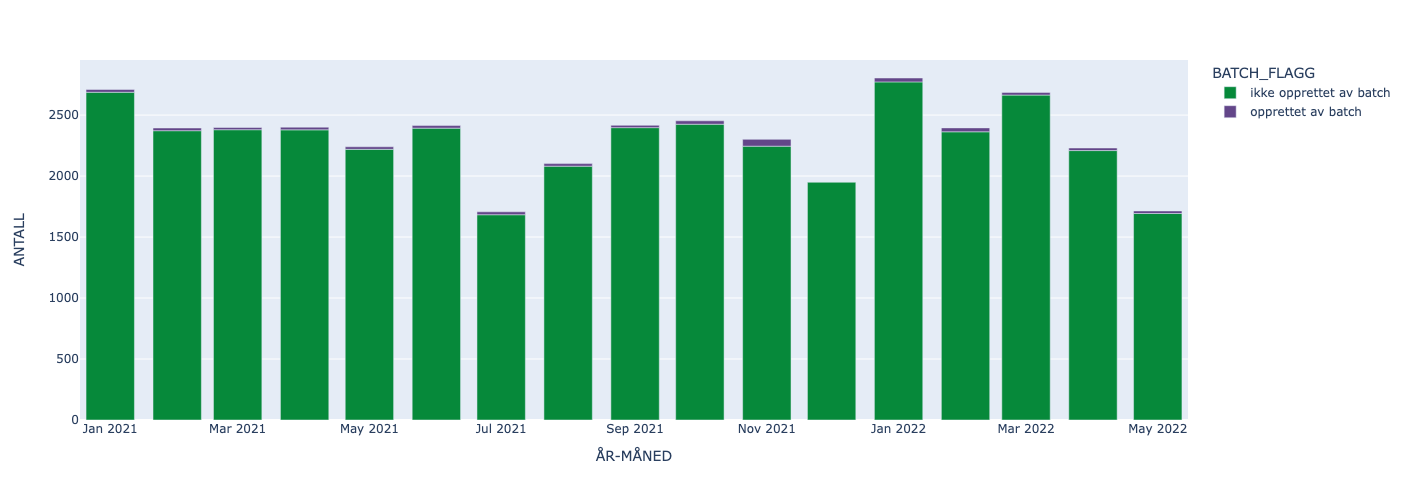

In [222]:
df_man_batch = df_man.groupby(["ÅR-MÅNED", "BATCH_FLAGG"], as_index=False).ANTALL.sum()

fig = px.bar(df_man_batch, "ÅR-MÅNED", "ANTALL", color="BATCH_FLAGG", color_discrete_sequence=nav_colors[2:])
fig.update_layout(
    autosize=False,
    width=1300,
    height=500,)
figs["man_batch"] = fig
fig.show()

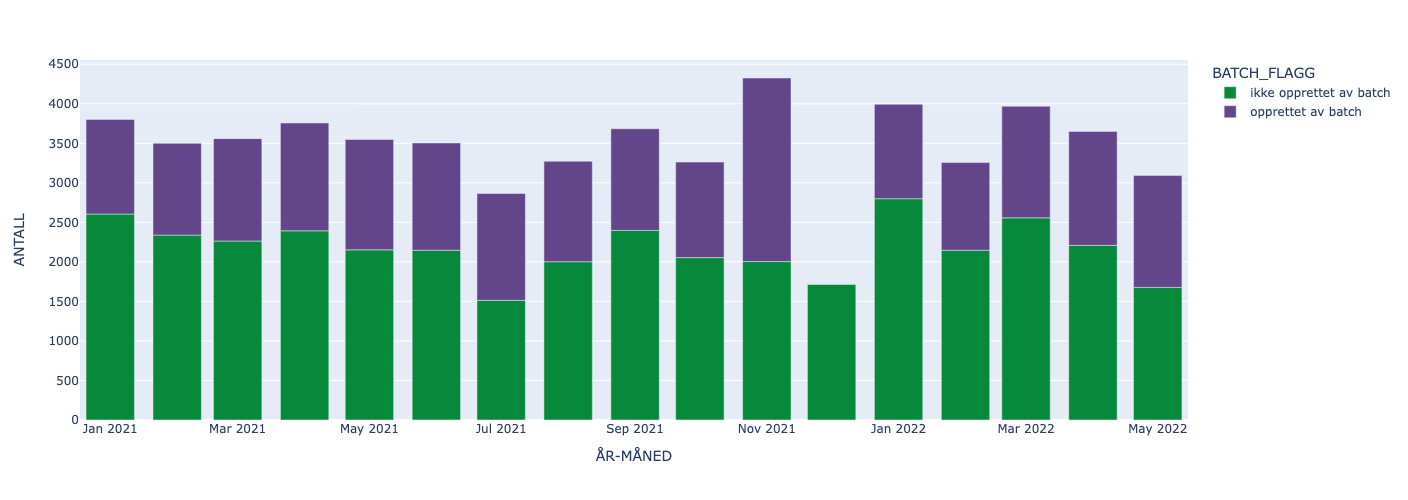

In [223]:
df_auto_batch = df_auto.groupby(["ÅR-MÅNED", "BATCH_FLAGG"], as_index=False).ANTALL.sum()

fig = px.bar(df_auto_batch, "ÅR-MÅNED", "ANTALL", color="BATCH_FLAGG", color_discrete_sequence=nav_colors[2:])
fig.update_layout(
    autosize=False,
    width=1300,
    height=500,)
figs["auto_batch"] = fig
fig.show()

# Sjekk plott

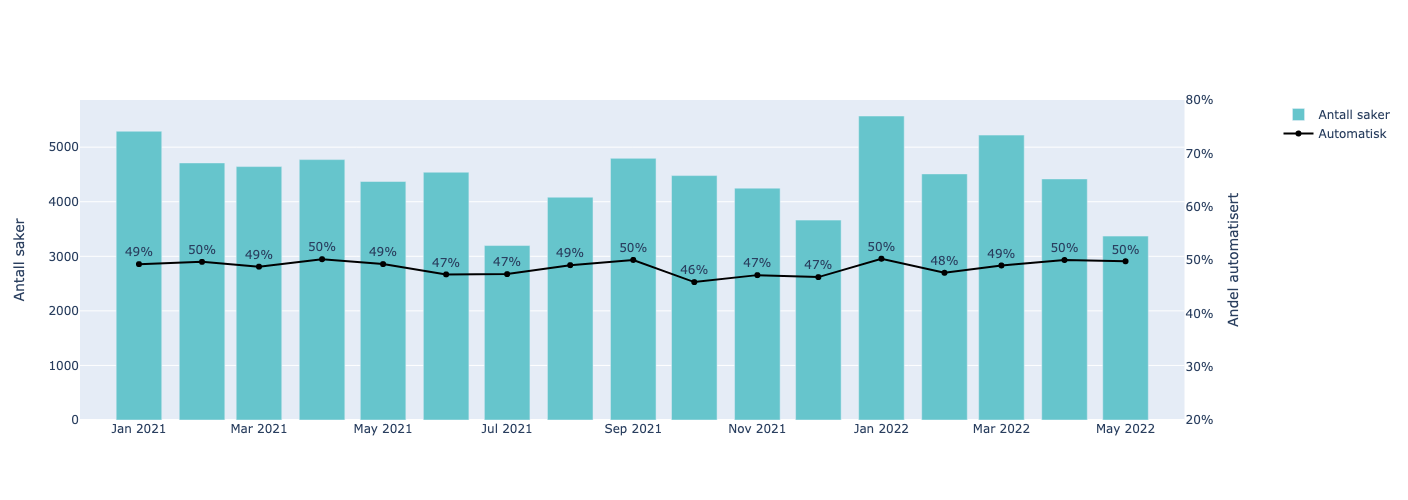

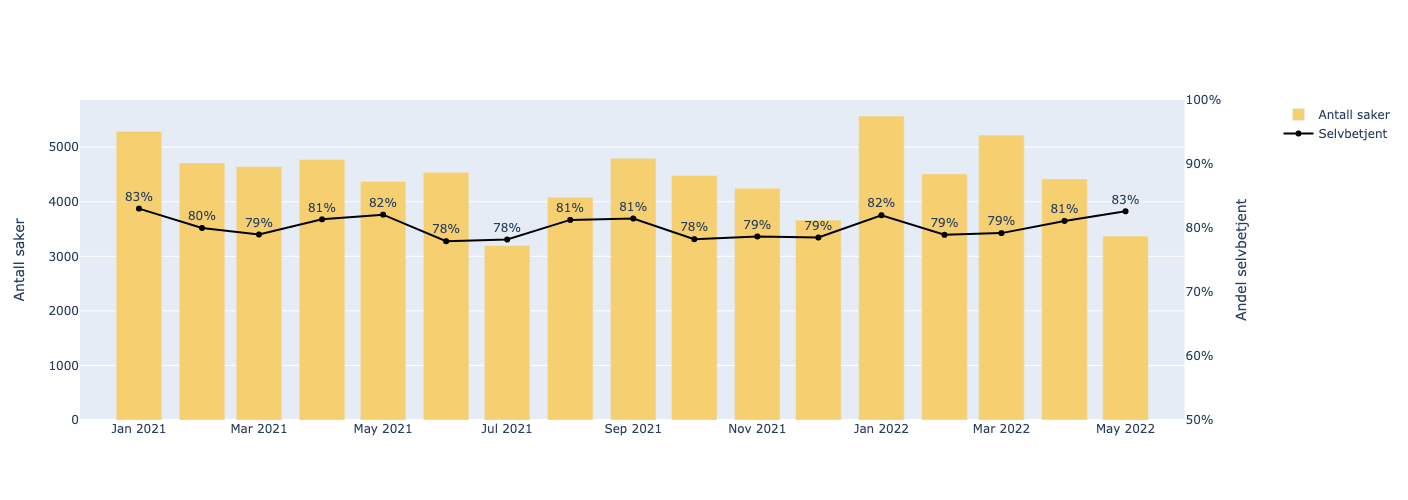

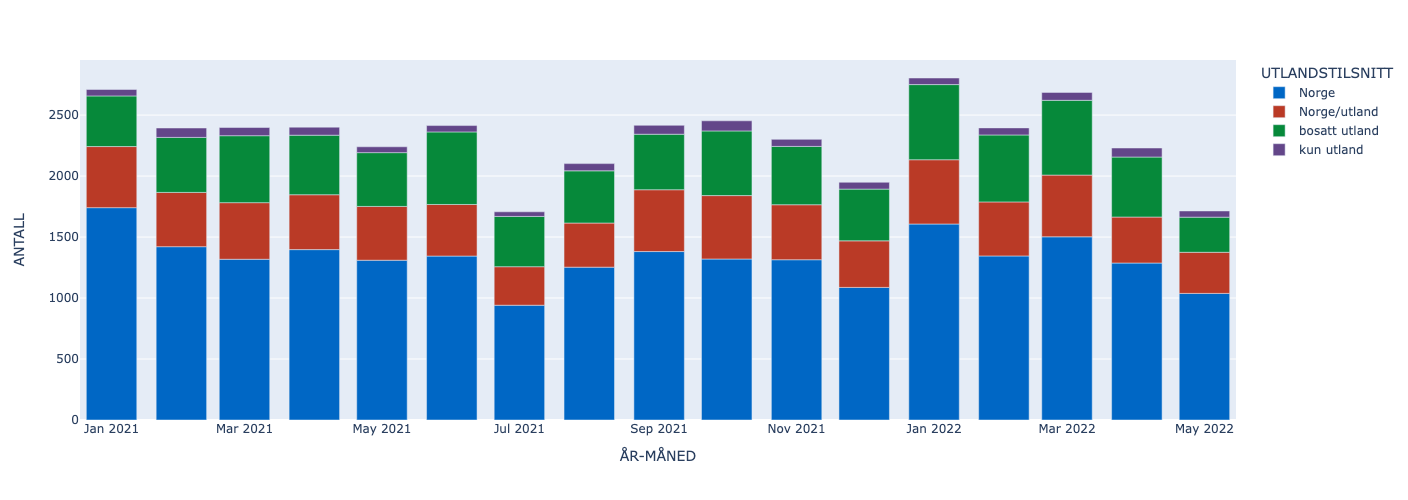

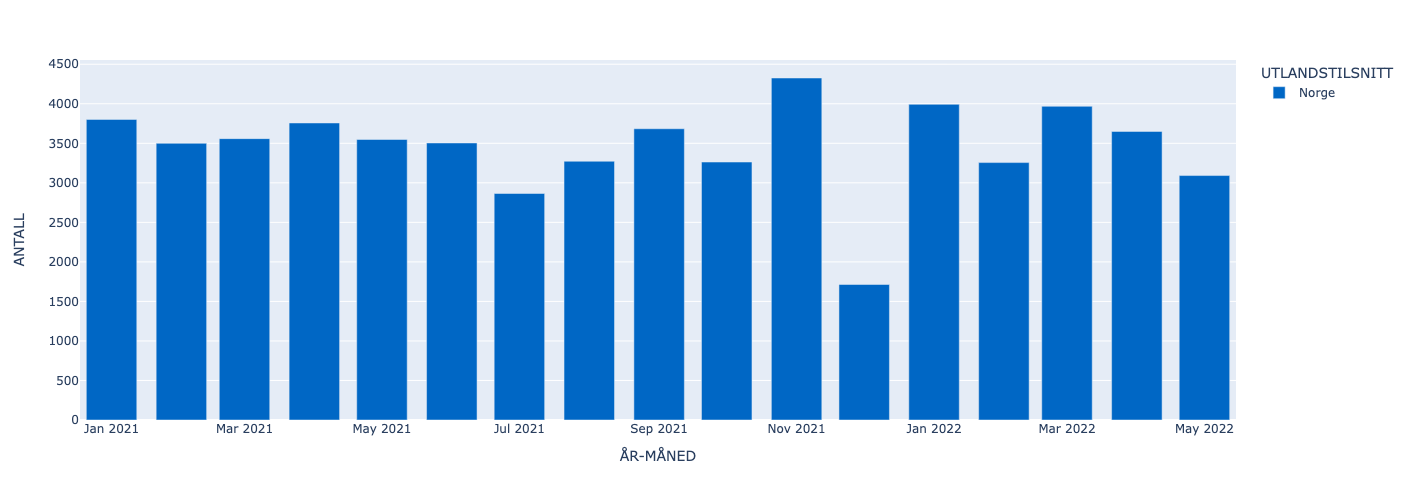

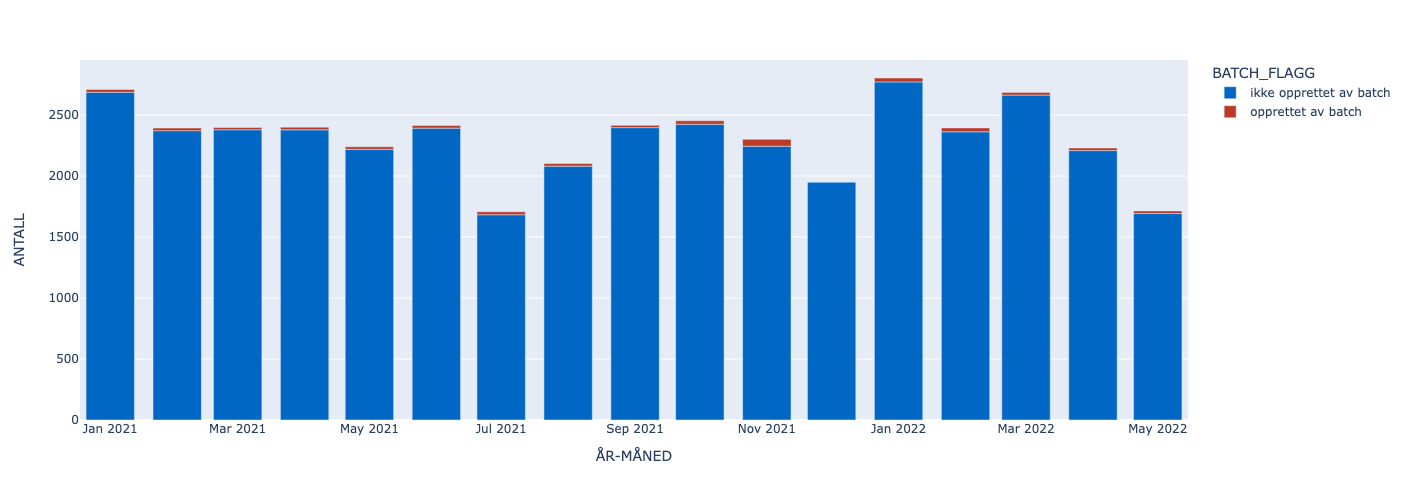

In [219]:
for _, fig in figs.items():
    fig.show()

# Publiser datastory

In [214]:
from datastory import DataStory

In [225]:
ds = DataStory(f"Automatiserings- og selvbetjeningsgrad for alderspensjon")

ds.markdown("**(Under utvikling)**")
ds.header(f"Automatisering av førstegangsbehandlingssaker for alderspensjon i pesys", level=2)
ds.markdown(f"Denne figuren gjelder kun førstegangsbehandling av alderspensjonssaker. Saker opprettet av batch er eksludert. For noen saker er deler av behandlingen automatisert, men disse regnes som manuelt behandlet.")
ds.plotly(figs["autograd"].to_json())

ds.header(f"Selvbetjening av førstegangsbehandlingssaker for alderspensjon i pesys", level=2)
ds.markdown(f"En sak regnes som selvbetjent dersom den er opprettet av en innbygger (ikke saksbehandler/batch). Denne figuren gjelder kun førstegangsbehandling av alderspensjonssaker. Saker opprettet av batch er eksludert.")
ds.plotly(figs["selvbetjening"].to_json())

ds.header(f"Hvordan påvirker utlandstilsnitt automatiseringsgrad ved førstegangsbehandling?", level=2)
ds.markdown(f"Utlandstilsnitt på *manuelt* behandlede saker.")
ds.plotly(figs["man_utland"].to_json())
ds.markdown(f"Utlandstilsnitt på *automatisk* behandlede saker.")
ds.plotly(figs["auto_utland"].to_json())

ds.header(f"Hvor mange saker opprettet av batch behandles automatisk?")
ds.markdown(f"*Manuelt* behandlede saker")
ds.plotly(figs["man_batch"].to_json())
ds.markdown(f"*Automatisk* behandlede saker")
ds.plotly(figs["auto_batch"].to_json())


In [226]:
ds.publish(url="https://nada.intern.nav.no/api") #prod

<IPython.core.display.Javascript object>

'https://data.intern.nav.no/story/draft/abcbb642-8b51-4da2-a4fe-941f16586135'

In [ ]:
#ds.update(token='77e7eb36-5a5b-4a9e-b6f9-ccee1c5db2e3')